In [88]:
# Variáveis Iniciais do Sistema
initial_date = "01-01-2020"
final_date = "31-12-2029"

# Regioes e Locais cadastrados no sistemas de SmartParking
parkings_data = [
    {
        "parking": "IPB",
        "regions": [
            {
                "name": "ipb-cantina",
                "open_time": "08:00",
                "close_time": "20:59",
                "max_slots": 300,
                
                "ocuppation_avg": 0.4,
                "ocuppation_variation": 0.25,
                
                "parking_time_min": 10,
                "parking_time_average": 25,
                "parking_time_max": 60,
                
                "weekday_flow": 1.0,
                "weekend_flow": 0.5,
                
                "rainy flow": 0.7,
                "sunny flow": 1.0,
                "weather_rain_chance": 0.05,
                
                "months_flow": {
                    "January": 1.0,
                    "February": 1.3,
                    "March": 1.0,
                    "April": 1.0,
                    "May": 1.0,
                    "June": 0.9,
                    "July": 0.6,
                    "August": 0.6,
                    "September": 1.3,
                    "October": 1.0,
                    "November": 1.0,
                    "December": 0.9
                },
                
                "year_increase_flow_max": 0.25,
                "year_decrease_flow_max": 0.1,
                
                "rush_range": [
                    {
                        "start": "12:00",
                        "finish": "14:00",
                        "flow": 2.5
                    },
                    {
                        "start": "18:00",
                        "finish": "19:00",
                        "flow": 1.8
                    }
                ]
            }
        ]
    }
]

In [89]:
# Importações de Bibliotecas Necessárias
import pandas as pd
import numpy as np
import time

from datetime import datetime
from datetime import timedelta  

from random import seed
from random import randint
from random import uniform

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib.dates as md

In [90]:
cols = ["parking","region","timeFrom","timeTo","weekday","spotWanted","spotWon"]

date = datetime.strptime(initial_date, '%d-%m-%Y')
end_date = datetime.strptime(final_date, '%d-%m-%Y')

for park in parkings_data:
    for region in park['regions']:
        region['open_time'] = datetime.strptime(region['open_time'], '%H:%M').time()
        region['close_time'] = datetime.strptime(region['close_time'], '%H:%M').time()
        for rush in region['rush_range']:
            rush['start'] = datetime.strptime(rush['start'], '%H:%M').time()
            rush['finish'] = datetime.strptime(rush['finish'], '%H:%M').time()

print("Start Generating On:", date.strftime('%d-%m-%Y'))
print("Finish Generating On:", end_date.strftime('%d-%m-%Y'))
days_total = (end_date - date).days
print("Total Days: ", days_total)

Start Generating On: 01-01-2020
Finish Generating On: 31-12-2029
Total Days:  3652


In [91]:
df = pd.DataFrame(columns=cols)

start_time = time.time()
print("Generating Data...\n")

# Zera a lista do estacionamento
parkings = []

# Verifica se o horario atual é um horário de maior fluxo para aquela região    
def is_rush_time(region):
    is_rush = False
    rush_increase = 1
    for rush in region['rush_range']:
        # Verifica se esta no horario de pico do Rush
        if (date.time() >= rush['start'] and date.time() <= rush['finish']):
            is_rush = True
            rush_increase = rush['flow']
            break
        # Verifica se esta à pelo menos 30 minutos antes do Rush (pre-rush)
        elif ( (date + timedelta(minutes=30)).time() >= rush['start'] and (date + timedelta(minutes=30)).time() <= rush['finish'] ):
            is_rush = True
            rush_increase = ((rush['flow'] - 1) / 2) + 1
            # Cria variacao de 15 porcento para mais ou menos (para nao gerar um padrao identico de pré/pós rush)
            last_variation = uniform(-0.1,0.1)
            rush_increase = rush_increase * (1-last_variation)
            break
        # Verifica se esta à pelo menos 30 minutos depois do Rush (pós-rush)
        elif ( (date - timedelta(minutes=30)).time() >= rush['start'] and (date - timedelta(minutes=30)).time() <= rush['finish'] ):
            is_rush = True
            rush_increase = ((rush['flow'] - 1) / 2) + 1
            # Cria variacao de 15 porcento para mais ou menos (para nao gerar um padrao identico de pré/pós rush)
            last_variation = uniform(-0.1,0.1)
            rush_increase = rush_increase * (1-last_variation)
            break   
              
        # Increase Some More Parkings When Nearing to the rush time and Increase Some Parkings time after the end rush's time
        #else if (date.time())
    return is_rush, rush_increase

# Define quantos parkings serao criados em cada execucao dependendo se a regiao esta ou nao em horario de maior fluxo
def add_parkings_by_rush(region):
    is_rush, rush_increase = is_rush_time(region)
    
    add_parkings = randint(1,24)
    if (is_rush):
        # Multiplicacao do anterior OU randint(1,3*increase) *****************
        add_parkings = add_parkings * rush_increase
        #add_parkings = randint(1,int(3*rush_increase))
        
    return add_parkings

# Verifica se é dia de semana / final de semana
def check_weekday(date):
    day = date.strftime('%A')
    if day == "Saturday" or day == "Sunday":
        return 0
    return 1

# Percorre cada Parking cadastrado
for park in parkings_data:
    var_parking = park['parking']
    print("Generating Data for Parking: ",var_parking)
    # Percorre cada Região do parking
    for region in park['regions']:
        var_region = region['name']
        print("\tGenerating Data for Region: ",var_region, " ...")
        
        # Obtem os horarios de abertura e fechamento da Região do Parking
        open_time = region['open_time']
        close_time = region['close_time']
        
        # Obtem o tempo minimo e maximo de estacionamentos no local
        parking_time_min = region['parking_time_min']
        parking_time_max = region['parking_time_max']
        parking_time_average = region['parking_time_average']
        if (parking_time_min == None):
            parking_time_min = 15
        if (parking_time_max == None):
            parking_time_max = 300
        if (parking_time_average == None):
            parking_time_average = 60
            
        # Zera lista de spots ocupados no estacionamento
        parking_spots = []
        parking_max_slots = region['max_slots']
        parking_empty_slots = parking_max_slots
        
        for c in range(parking_max_slots):
            parking_spots.append(None)
        
        # Zera a data de inicio e fim para iniciar a criacao de dados
        date = datetime.strptime(initial_date, '%d-%m-%Y')
        date = date.replace(hour=open_time.hour, minute=open_time.minute)
        
        end_date = datetime.strptime(final_date, '%d-%m-%Y')
        end_date = end_date.replace(hour=close_time.hour, minute=close_time.minute)  
        
        rushs = 0
        notrushs = 0
        
        weekday_flow = region['weekday_flow']
        weekend_flow = region['weekend_flow']
        months_flow = region['months_flow']
        
        year_increase_flow_max = region['year_increase_flow_max']
        year_decrease_flow_max = region['year_decrease_flow_max']
        current_year = date.year
        cumulative_year_ratio = 1

        while(date <= end_date):
            
            # Define o percentual de vagas que serao adicionados (inicial 1 = 100%)
            parking_ratio = 1
            
            # [1 - Variaveis de Padronizacao] Calcula Impacto de horarios de alto fluxo (Rush Hours)
            check_rush,rush_increase = is_rush_time(region)
            if (check_rush):
                parking_ratio = parking_ratio * rush_increase

            # [2 - Variaveis de Padronizacao] Calcula Impacto do Fim de Semana (WeekDays/WeekendDays)
            is_weekday = check_weekday(date)
            if (is_weekday == 1):
                parking_ratio = parking_ratio * weekday_flow               
            else:
                parking_ratio = parking_ratio * weekend_flow

            # [3 - Variaveis de Padronizacao] Calcula Impacto do Clima Atual (Rainy/Sunny)


            # [4 - Variaveis de Padronizacao] Calcula o Impacto de Feriados (Holidays)
                
                
            # [5 - Variaveis de Padronizacao] Calcula o Impacto do MES ATUAL no fluxo
            current_month = months_flow[date.strftime('%B')]
            parking_ratio = parking_ratio * current_month * (1-uniform(-0.15,0.15))
            
            # [6 - Variaveis de Padronizacao] Calcula o Impacto do ANO ATUAL no fluxo
            if (date.year != current_year):
                current_year = date.year
                cumulative_year_ratio = cumulative_year_ratio * (1 + uniform(year_decrease_flow_max, year_increase_flow_max))
                print(current_year," -> ",cumulative_year_ratio)
                print("Parking Ratio: ", parking_ratio * cumulative_year_ratio)
                print("-------------")
            parking_ratio = parking_ratio * cumulative_year_ratio
            
            # [7 - Variacao do numero de estacionamentos no fim do dia]
            if ((date + timedelta(minutes=40)).time() >= close_time):
                parking_ratio = parking_ratio * 0.8
            
            # [8 - Variacao Final para nao criar padroes obvios e repetitivos]
            last_variation = uniform(-0.1,0.1)
            bkp = parking_ratio
            parking_ratio = parking_ratio * (1-last_variation)
            
            # Insere estacionamentos na base de dados
            MAX_ADD = 4
            
            add_parkings = 0
            if (int(MAX_ADD*parking_ratio) != 0):
                add_parkings = randint(1,int(MAX_ADD*parking_ratio))
            
            while(add_parkings != 0):
                # Chance do estaciomamento durar: [ Ate 60min : 70%  | Acima de 60min: 30% ]
                parking_time = randint(parking_time_min,parking_time_average)
                if (randint(1,10) > 5):
                    parking_time = randint(parking_time_average,parking_time_max)

                # Cria uma ROW
                row = {'parking': var_parking, 'region': var_region}
                row.update({'weekday': is_weekday})
                row.update({'timeFrom': date.strftime('%d-%m-%Y %H:%M')})

                # Adiciona o Role ***********************************************
                
                validate_date = date + timedelta(minutes=parking_time)

                # Caso o tempo de estacionamento seja maior ou igual o limite do horario do estacionamento
                if (validate_date.hour >= close_time.hour and validate_date.minute >= close_time.minute) or (validate_date.hour > close_time.hour):
                    t1 = timedelta(hours=date.hour, minutes=date.minute)
                    t2 = timedelta(hours=close_time.hour, minutes=close_time.minute)
                    new_time = int ( (t2 - t1).total_seconds() / 60 )
                                        
                    # Caso seja um estacionamento ate 15 minutos acima do limite minimo
                    if (new_time <= parking_time_min + 15):
                        if (new_time > 15):
                            new_parking_time = randint(0, (new_time-15) )
                        else:
                            new_parking_time = randint(0, (15-new_time) )
                        validate_date = date.replace(hour=close_time.hour, minute=close_time.minute) - timedelta(minutes=new_parking_time)                  
                        row.update({'timeTo': (date.replace(hour=validate_date.hour, minute=validate_date.minute).strftime('%d-%m-%Y %H:%M')) })

                    # Caso seja um estacionamento 15 minutos ou mais acima do limite minimo
                    else:
                        new_parking_time = randint(parking_time_min, new_time-parking_time_min )
                        validate_date = date.replace(hour=close_time.hour, minute=close_time.minute) - timedelta(minutes=new_parking_time)
                        row.update({'timeTo': (date.replace(hour=validate_date.hour, minute=validate_date.minute).strftime('%d-%m-%Y %H:%M')) })                    
     
                # Caso o tempo de estacionamento seja muito maior que o limite do horario do estacionamento
                elif (validate_date.hour < open_time.hour):
                    row.update({'timeTo': (date.replace(hour=close_time.hour, minute=close_time.minute).strftime('%d-%m-%Y %H:%M')) })
                # Caso o tempo final do estacionamento esteja dentro do limite do horario
                else:
                    row.update({'timeTo': validate_date.strftime('%d-%m-%Y %H:%M')})


                # ***********************************************************************************

                # [SPOT NUMBER] Encontra um SpotID vago para o usuario
                spot_found = False
                spot_id = -1

                # Define aleatoriamente um Spot de vaga "Desejado" pelo Usuario
                try_spot = randint(0,parking_max_slots-1)
                row.update({'spotWanted': try_spot})

                # Tenta encontrar em um spot disponivel de forma aleatoria por 10 tentativas
                for c in range(1,10):
                    if (parking_spots[try_spot] == None):
                        spot_found = True
                        spot_id = try_spot
                        parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                        break
                    try_spot = randint(0,parking_max_slots-1)

                # Caso nao encontre em 10 tentativas aleatorias -> seleciona o primeiro disponivel em ordem crescente
                if not (spot_found):
                    for c in range(len(parking_spots)):
                        if (parking_spots[c] == None):
                            spot_id = c
                            parking_spots[spot_id] = datetime.strptime(row['timeTo'], '%d-%m-%Y %H:%M')
                            break

                row.update({'spotWon': spot_id}) 

                # Finaliza o Role ***********************************************                
                parkings.append(row)

                # Libera Espacos vagos no estacionamento
                for c in range(len(parking_spots)):
                    if (parking_spots[c] != None):
                        if (parking_spots[c] <= date):
                            parking_spots[c] = None
                            
                # 
                if (len(parkings) >= 50000):
                    print("\t\t50.000 Generated! ...")
                    df = df.append(parkings, ignore_index=True)
                    parkings = []
                            
                add_parkings -= 1
                
            addMin = randint(0,6)
            date = date + timedelta(minutes=addMin)

            # Verifica se a nova hora e data é valida
            if not(date.time() >= open_time and date.time() <= close_time):
                date = date + timedelta(days=1)
                date = date.replace(hour=open_time.hour, minute=open_time.minute)
            elif ((date + timedelta(minutes=15)).time() >= close_time):
                date = date + timedelta(days=1)
                date = date.replace(hour=open_time.hour, minute=open_time.minute)
                
            if (date >= end_date):
                break
                    
    print("\n")
    
end_time = time.time()
final_time = datetime.fromtimestamp((end_time-start_time))
final_time = final_time.replace(microsecond=0)
df = df.append(parkings, ignore_index=True)
print("\nTime Spent: ",final_time.time())
print("Done!")

Generating Data...

Generating Data for Parking:  IPB
	Generating Data for Region:  ipb-cantina  ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
2021  ->  1.121471804193746
Parking Ratio:  1.206417177397517
-------------
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
2022  ->  1.397687427690739
Parking Ratio:  0.6359508068920853
-------------
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
2023  ->  1.5851351431959655
Parking Ratio:  0.6904333513225945
-------------
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
		50.000 Generated! ...
2024  ->  1.9211854081397752
Parking Ratio:  1.7016327990706064
-------------
		50.000 Generated! ...
		50.000 Gener

In [92]:
df

,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon
0,IPB,ipb-cantina,01-01-2020 08:00,01-01-2020 08:13,1,173,173
1,IPB,ipb-cantina,01-01-2020 08:01,01-01-2020 08:26,1,96,96
2,IPB,ipb-cantina,01-01-2020 08:01,01-01-2020 08:34,1,91,91
3,IPB,ipb-cantina,01-01-2020 08:07,01-01-2020 08:18,1,139,139
4,IPB,ipb-cantina,01-01-2020 08:13,01-01-2020 08:27,1,93,93
...,...,...,...,...,...,...,...
5006741,IPB,ipb-cantina,31-12-2029 20:35,31-12-2029 20:50,1,242,242
5006742,IPB,ipb-cantina,31-12-2029 20:41,31-12-2029 20:54,1,298,298
5006743,IPB,ipb-cantina,31-12-2029 20:41,31-12-2029 20:58,1,239,239
5006744,IPB,ipb-cantina,31-12-2029 20:41,31-12-2029 20:59,1,93,200


In [93]:
dfx = df[df['spotWon'] == -1]
dfx

,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon
2714759,IPB,ipb-cantina,28-01-2027 13:33,28-01-2027 14:24,1,139,-1
2714760,IPB,ipb-cantina,28-01-2027 13:33,28-01-2027 13:59,1,244,-1
2714761,IPB,ipb-cantina,28-01-2027 13:33,28-01-2027 14:02,1,169,-1
2714762,IPB,ipb-cantina,28-01-2027 13:33,28-01-2027 13:46,1,100,-1
2714763,IPB,ipb-cantina,28-01-2027 13:33,28-01-2027 13:53,1,94,-1
...,...,...,...,...,...,...,...
4967450,IPB,ipb-cantina,13-12-2029 13:25,13-12-2029 13:42,1,17,-1
4967451,IPB,ipb-cantina,13-12-2029 13:25,13-12-2029 13:42,1,113,-1
4967452,IPB,ipb-cantina,13-12-2029 13:25,13-12-2029 13:52,1,257,-1
4967453,IPB,ipb-cantina,13-12-2029 13:25,13-12-2029 14:16,1,173,-1


In [94]:
print("Writing output file...")
df.to_csv('generated_dataset_v4.csv', index=False)
print("Done!")

Writing output file...
Done!


In [95]:
print("Reading CSV...")
df = pd.read_csv('generated_dataset_v4.csv')
#df = df.drop('timeTo',axis=1)

print("Setting the Pattern in DateTime Columns...")
df['timeFrom'] = pd.to_datetime(df['timeFrom'], errors='ignore')
df['timeFrom'] = pd.to_datetime(df["timeFrom"].dt.strftime('%d-%m-%Y %H:%M'))

print("Done!")

df

Reading CSV...
Setting the Pattern in DateTime Columns...
Done!


,parking,region,timeFrom,timeTo,weekday,spotWanted,spotWon
0,IPB,ipb-cantina,2020-01-01 08:00:00,01-01-2020 08:13,1,173,173
1,IPB,ipb-cantina,2020-01-01 08:01:00,01-01-2020 08:26,1,96,96
2,IPB,ipb-cantina,2020-01-01 08:01:00,01-01-2020 08:34,1,91,91
3,IPB,ipb-cantina,2020-01-01 08:07:00,01-01-2020 08:18,1,139,139
4,IPB,ipb-cantina,2020-01-01 08:13:00,01-01-2020 08:27,1,93,93
...,...,...,...,...,...,...,...
5006741,IPB,ipb-cantina,2029-12-31 20:35:00,31-12-2029 20:50,1,242,242
5006742,IPB,ipb-cantina,2029-12-31 20:41:00,31-12-2029 20:54,1,298,298
5006743,IPB,ipb-cantina,2029-12-31 20:41:00,31-12-2029 20:58,1,239,239
5006744,IPB,ipb-cantina,2029-12-31 20:41:00,31-12-2029 20:59,1,93,200


In [96]:
df1 = df.copy()
df1 = df1[['timeFrom','weekday']]

print("Setting the Pattern in DateTime Columns...")
df1['timeFrom'] = pd.to_datetime(df1['timeFrom'], errors='ignore')

print("Grouping by Day...")
df1 = df1.groupby(df1['timeFrom'].dt.date).size().reset_index(name='TotalParkings')

print("Done!")
df1

Setting the Pattern in DateTime Columns...
Grouping by Day...
Done!


,timeFrom,TotalParkings
0,2020-01-01,809
1,2020-01-02,786
2,2020-01-03,748
3,2020-01-04,448
4,2020-01-05,413
...,...,...
3648,2029-12-27,2649
3649,2029-12-28,2614
3650,2029-12-29,1207
3651,2029-12-30,1316


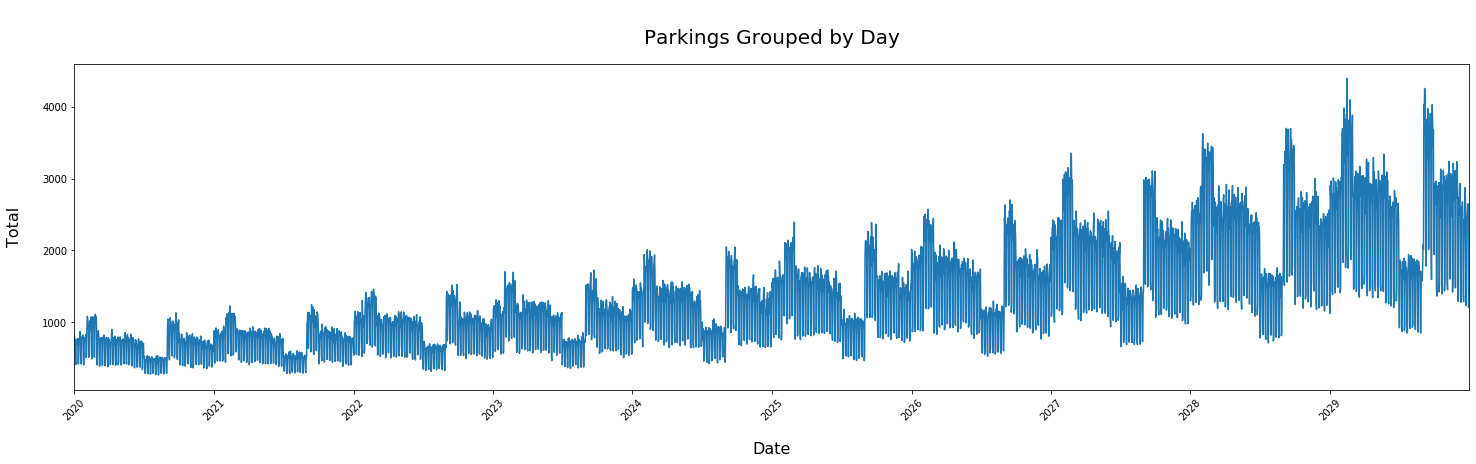

In [97]:
df3 = df1.copy()
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(25,6))
plt.title("\nParkings Grouped by Day", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.plot(df3)

In [98]:
df2 = df1.copy()
print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
df2 = df2.groupby(pd.Grouper(freq='M', key='timeFrom')).sum().reset_index()
df2['timeFrom'] = df2['timeFrom'].dt.strftime('%m-%Y')

print("Done!")
df2

Setting the Pattern in DateTime Columns...
Grouping by Month
Done!


,timeFrom,TotalParkings
0,01-2020,21164
1,02-2020,24944
2,03-2020,20747
3,04-2020,20156
4,05-2020,20259
...,...,...
115,08-2029,47405
116,09-2029,94678
117,10-2029,77956
118,11-2029,77607


Grouping by Month


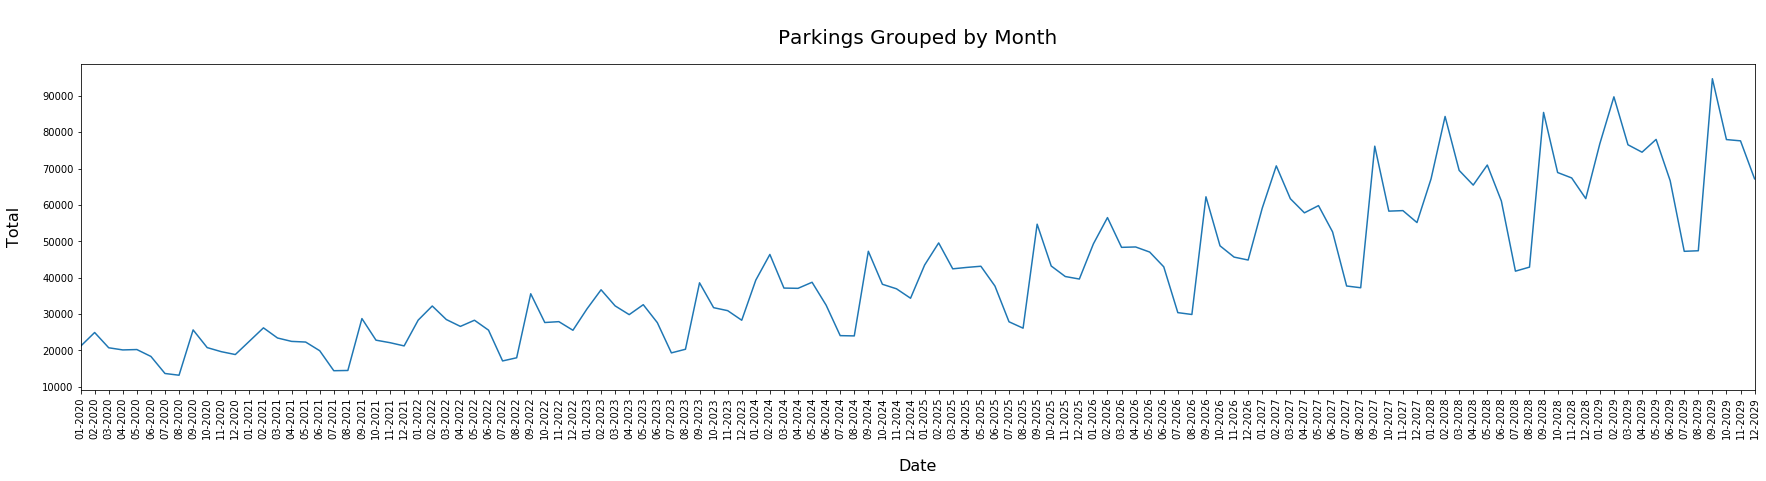

In [99]:
df3 = df2.copy()

print("Grouping by Month")
df3 = df3.set_index('timeFrom')

plt.subplots(figsize=(30,6))
plt.title("\nTotal: "+str(len(df['timeTo'])), fontsize=30, pad=20)
plt.title("\nParkings Grouped by Month", fontsize=20, pad=20)
plt.xlabel("Date", fontsize=16, labelpad=20)
plt.ylabel("Total", fontsize=16, labelpad=20)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))
plt.xticks(rotation=90)

plt.plot(df3)

In [100]:
df4 = df.copy()
df4 = df4[['timeFrom','timeTo']]

print("Setting the Pattern in DateTime Columns...")
df4['timeFrom'] = pd.to_datetime(df4['timeFrom'], errors='ignore')
df4['timeFrom'] = pd.to_datetime(df4["timeFrom"].dt.strftime('%d/%m/%Y %H:%M'))

df4['timeTo'] = pd.to_datetime(df4['timeTo'], errors='ignore')
df4['timeTo'] = pd.to_datetime(df4["timeTo"].dt.strftime('%d/%m/%Y %H:%M'))

# Query For Specific Day
print("Setting Query for Specific Day and Month...")
df4 = df4[(df4['timeFrom'].dt.month == 1) & (df4['timeFrom'].dt.day == 15)]

print("Generating Graph...")
fig, ax = plt.subplots(figsize=(15,15))

max_y = 0
min_x = 0

while ((df4['timeTo'].max().minute + max_y) % 30 != 0):
    max_y += 1
    
while ((df4['timeFrom'].min().minute + min_x) % 30 != 0):
    min_x -= 1

min_x = min_x + 30
max_y = max_y + 30
    
plt.scatter(x=df4['timeFrom'], y=df4['timeTo'])

ax.set_xlim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.set_ylim(df4['timeFrom'].min()-pd.Timedelta(min_x,'m'),
            df4['timeTo'].max()+pd.Timedelta(max_y,'m'))

ax.xaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

ax.yaxis.set_major_locator(md.MinuteLocator(interval = 30))
ax.yaxis.set_major_formatter(md.DateFormatter('%H:%M'))

fig.autofmt_xdate()

plt.title("\nTotal Parkings of One Day (15/01/2020)", fontsize=30, pad=20)
plt.xlabel("Entry DateTime", fontsize=20, labelpad=20)
plt.ylabel("Exit DateTime", fontsize=20, labelpad=20)

plt.xticks(rotation=90)

plt.margins(x=0)
plt.figure(1).set_facecolor((1, 1, 1))

plt.grid()
plt.show()

Setting the Pattern in DateTime Columns...
Setting Query for Specific Day and Month...
Generating Graph...


RuntimeError: Locator attempting to generate 157853 ticks from 737439.3125 to 740727.8958333334: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 157853 ticks from 737439.3125 to 740727.8958333334: exceeds Locator.MAXTICKS

In [ ]:
# Query For Specific Day
print("Setting Query for Specific Day and Month...")

df2 = df.copy()
df2 = df2.drop(df2.columns.difference(['timeFrom']), axis=1)

print("Setting the Pattern in DateTime Columns...")
df2['timeFrom'] = pd.to_datetime(df2['timeFrom'], errors='ignore')

df2 = df2[(df2['timeFrom'].dt.month == 1) & (df2['timeFrom'].dt.day == 15)]

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
print("Grouping by Month")
#df2 = df2.groupby(pd.Grouper(freq='H', key='timeFrom')).sum().reset_index()

df2 = df2.groupby(df2['timeFrom'].dt.hour).size().reset_index(name='TotalParkings')

print("Done!")
df2

plt.subplots(figsize=(10,6))
plt.grid()
plt.locator_params(axis='x', nbins=24)
plt.bar(df2['timeFrom'],df2['TotalParkings'])

plt.title("\nTotal Parkings of One Day (15/01/2020)", fontsize=20, pad=20)
plt.xlabel("Entry Hour", fontsize=20, labelpad=20)
plt.ylabel("Total Parkings", fontsize=20, labelpad=20)

plt.figure(1).set_facecolor((1, 1, 1))
plt.show()

In [ ]:
# Query For Specific Day
print("Setting Query for Specific Day and Month...")

df2 = df.copy()
df3 = df.copy()

df2 = df2.drop(df2.columns.difference(['timeTo']), axis=1)
df3 = df3.drop(df3.columns.difference(['timeFrom']), axis=1)

print("Setting the Pattern in DateTime Columns...")
df2['timeTo'] = pd.to_datetime(df2['timeTo'], errors='ignore')
df3['timeFrom'] = pd.to_datetime(df3['timeFrom'], errors='ignore')

print("Grouping by Hour...")
df2 = df2.groupby(df2['timeTo'].dt.hour).size().reset_index(name='TotalParkings')
df3 = df3.groupby(df3['timeFrom'].dt.hour).size().reset_index(name='TotalParkings')

df2 = df2.rename(columns={'timeTo':'Hour'})
df3 = df3.rename(columns={'timeFrom':'Hour'})

df3.insert(0, 'Type', 'Enter')
df2.insert(0, 'Type', 'Exit')

df2 = pd.concat([df2, df3],ignore_index=True)

#plt.title("\nTotal Parkings of Dataset (Grouped by Hour)", fontsize=20, pad=20)
#plt.xlabel("Exit Hour", fontsize=20, labelpad=20)
#plt.ylabel("Total Parkings", fontsize=20, labelpad=20)

fig, ax = plt.subplots(figsize=(20,14),nrows=2)
fig.subplots_adjust(hspace=0.4)

graph = sns.barplot(ax=ax[0], x = 'Hour', y='TotalParkings', hue = 'Type', data=df2)
graph.axes.set_title("Total Parkings of Dataset Grouped By Hour",fontsize=25)
graph.set_xlabel("Hour",fontsize=18)
graph.set_ylabel("Total Parkings",fontsize=18)
graph.tick_params(labelsize=14)
graph.grid()
plt.setp(graph.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(graph.get_legend().get_title(), fontsize='20') # for legend title
plt.figure(1).set_facecolor((1, 1, 1))

graph2 = sns.lineplot(ax=ax[1], x = 'Hour', y='TotalParkings', hue = 'Type', data=df2, lw=4.5)
graph2.set_xticks(range(df2['Hour'].min(),df2['Hour'].max()+1))
graph2.axes.set_title("Total Parkings of Dataset Grouped By Hour",fontsize=25)
graph2.set_xlabel("Hour",fontsize=18)
graph2.set_ylabel("Total Parkings",fontsize=18)
graph2.tick_params(labelsize=14)
graph2.grid()
plt.setp(graph2.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(graph2.get_legend().get_title(), fontsize='20') # for legend title
plt.figure(2).set_facecolor((1, 1, 1))


plt.show()

In [ ]:
dfx = df.copy()
print("Grouping by SpotWon...")

xs = dfx.groupby('spotWon')['timeTo'].nunique().sort_values(ascending=False).reset_index(name='TotalWons')

xs

In [ ]:
dfx = df.copy()

wanted_equals_won = [dfx[dfx['spotWon'] == dfx['spotWanted']].count().max()][0]
wanted_dif_won = [dfx[dfx['spotWon'] != dfx['spotWanted']].count().max()][0]

print("Same Spot Wanted & Won: ",wanted_equals_won)
print("Different Spot Wanted & Won: ",wanted_dif_won)

print("\nTotal Parkings: ",wanted_equals_won+wanted_dif_won)
print("Request Sucess Rate: %0.2f%%" % ((wanted_equals_won * 100 / (wanted_equals_won+wanted_dif_won))) )